# Decompacting stratigraphic layers

In this example we visualize the decompaction of stratigraphic layers at several drill sites, and overlay tectonic subsidence to compare its subsidence contribution with that of sedimentation.

We *backstrip* one shallow continental drill site to obtain tectonic subsidence from recorded paleo water depths. We then *backtrack* (instead of *backstrip*) a different shallow continental drill site (containing no recorded paleo water depths) to obtain paleo water depths from a model of *continental* tectonic subsidence. We then *backtrack* an oceanic drill site to obtain paleo water depths from a model of *oceanic* tectonic subsidence.

Note that regardless of whether we're backstripping or backtracking we are still decompacting the sediment layers. The main difference is how tectonic subsidence and water depths are obtained.


## Reference

The following paper covers the theory and algorithms of pyBacktrack:

* Müller, R. D., Cannon, J., Williams, S. and Dutkiewicz, A., 2018,
  PyBacktrack 1.0: A Tool for Reconstructing Paleobathymetry on Oceanic and Continental Crust,
  **Geochemistry, Geophysics, Geosystems,** 19, 1898-1909, doi: [10.1029/2017GC007313](https://doi.org/10.1029/2017GC007313)

In [1]:
import pybacktrack

# A shallow continental drill site file used with backstripping.
backstrip_well_filename = '../example_data/sunrise_lithology.txt'

# An oceanic drill site file used with backtracking.
backtrack_oceanic_well_filename = '../example_data/ODP-114-699-Lithology.txt'

# A shallow continental drill site file used with backtracking.
backtrack_continental_well_filename = '../example_data/DSDP-36-327-Lithology.txt'

In [2]:
import warnings

# Ignore user warnings related to well thickness being larger than total sediment thickness.
#
# This happens because the default total sediment thickness grid is not as accurate near continental margins
# like the 'sunrise' drill site (compared to deeper ocean basins).
warnings.filterwarnings("ignore", "Well thickness .* is larger than the total sediment thickness")

# Ignore user warnings related to dynamic topography sampling.
#
# This happens when the age of interpolated dynamic topography grids are older than the crust at the drill site location.
warnings.filterwarnings("ignore", "Dynamic topography model .* cannot")

## Function to gather the depths of decompacted stratigraphic layers

This function accumulates the decompacted thicknesses of stratigraphic layers at each age. This is so we know the depth of each decompacted sediment layer below sea level. It also gathers other quantities such as sea level, water depth, tectonic subsidence and dynamic topography.

In [3]:
def get_decompacted_sediment_depths(
        well,
        decompacted_sections,
        dynamic_topography_model):
    """
    Return the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # 'decompacted_sections' is a list of pybacktrack.DecompactedWell.
    # Each decompacted section is a single pybacktrack.DecompactedWell that represents
    # the stratigraphic section of the well when it is decompacted at a particular time
    # (the time of one of its stratigraphic units).
    #
    # Extract the age, water depth, tectonic subsidence and
    # decompacted depths from each decompacted section in the list.
    ages = []
    sea_level_depths = []
    surface_sediment_depths = []
    tectonic_subsidences = []
    dynamic_topography_depths = []

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(well.stratigraphic_units)
    # Each stratigraphic layer will have its own depth vs age curve.
    # Start with an empty list for each layer.
    all_stratigraphic_unit_depths = [[] for i in range(num_stratigraphic_units)]

    # Each successive decompacted section involves stripping off a stratigraphic layer.
    for decompacted_section in decompacted_sections:
        # Keep track of the ages of the top of each stratigraphic layer.
        age = decompacted_section.get_age()
        ages.append(age)

        # Keep track of the sea level (relative to present day) at each age.
        #
        # NOTE: Positive values represent sea-level rise which is the opposite of depth
        # (which is positive going down).
        # So we need to negate sea level to turn a rise into a depth.
        sea_level = decompacted_section.get_sea_level()
        sea_level_depth = -sea_level
        sea_level_depths.append(sea_level_depth)

        # Keep track of the surface sediment depth at each age.
        water_depth = decompacted_section.get_water_depth()
        surface_sediment_depth = sea_level_depth + water_depth
        surface_sediment_depths.append(surface_sediment_depth)

        # Keep track of the tectonic subsidence at each age.
        tectonic_subsidence = decompacted_section.get_tectonic_subsidence()
        tectonic_subsidences.append(tectonic_subsidence)

        # Keep track of the dynamic topography at each age.
        #
        # NOTE: Positive values represent elevation which is the opposite of subsidence
        # (which is positive going down).
        # So we need to negate dynamic topography to turn an elevation into a depth.
        dynamic_topography = dynamic_topography_model.sample(decompacted_section.get_age())
        dynamic_topography_depth = -dynamic_topography
        dynamic_topography_depths.append(dynamic_topography_depth)

        # The number of decompacted stratigraphic layers decreases by one each loop iteration.
        num_decompacted_stratigraphic_units = len(decompacted_section.decompacted_stratigraphic_units)

        # The depth of the current surface layer starts at the surface sediment depth.
        total_decompacted_depth = surface_sediment_depth

        # Iterate over the stratigraphic layers that have already been removed.
        # We'll just give them the current surface sediment depth so
        # we can easily fill colours between curves below.
        stratigraphic_unit_index = 0
        while stratigraphic_unit_index < num_stratigraphic_units - num_decompacted_stratigraphic_units:
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(surface_sediment_depth)
            stratigraphic_unit_index += 1

        # Iterate over the stratigraphic layers still existing at the current time.
        # Each layer has a decompacted thickness which adds to the decompacted depth.
        for decompacted_stratigraphic_unit in decompacted_section.decompacted_stratigraphic_units:
            total_decompacted_depth += decompacted_stratigraphic_unit.decompacted_thickness
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(total_decompacted_depth)
            stratigraphic_unit_index += 1
        
    return (ages, sea_level_depths, surface_sediment_depths,
            tectonic_subsidences, dynamic_topography_depths, all_stratigraphic_unit_depths)

## Function to plot decompacted stratigraphic layers and tectonic subsidence

This function plots a "depth vs age" curve for each stratigraphic layer in the drill site. It also plots other quantities such as sea level, water depth, tectonic subsidence and dynamic topography.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

# Choose a colour for each stratigraphic unit.
stratigraphic_unit_colours = [
    'mistyrose', 'bisque', 'lemonchiffon', 'lightgreen', 'aquamarine', 'powderblue', 'lavender', 'thistle']

def plot_decompacted_sediment_depths(
        ages,
        sea_level_depths,
        surface_sediment_depths,
        tectonic_subsidences,
        dynamic_topography_depths,
        all_stratigraphic_unit_depths):
    """
    Plot the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(all_stratigraphic_unit_depths)
    
    plt.figure(figsize=(8,8))
    plt.title('Geohistory analysis', fontsize=16)

    for stratigraphic_unit_index in range(num_stratigraphic_units):
        # Plot a grey line at the top of the current stratigraphic unit.
        plt.plot(
            ages,
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            color='grey',
            linewidth=1.0)
        # Fill the current stratigraphic layer with a colour.
        plt.fill_between(
            ages,
            (all_stratigraphic_unit_depths[stratigraphic_unit_index-1]
                 if stratigraphic_unit_index > 0
                 else surface_sediment_depths),
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            facecolor=stratigraphic_unit_colours[stratigraphic_unit_index % len(stratigraphic_unit_colours)])

    # Fill blue from sea-level depth down to surface sediment depth to indicate water.
    plt.fill_between(
        ages,
        sea_level_depths,
        surface_sediment_depths,
        facecolor='royalblue')

    # Plot surface sediment depth.
    plt.plot(
        ages,
        surface_sediment_depths,
        color='black',
        label='surface sediment',
        linestyle='-',
        linewidth=2.0)

    # Plot tectonic subsidence.
    plt.plot(
        ages,
        tectonic_subsidences,
        color='black',
        label='tectonic subsidence',
        linestyle='--',
        linewidth=2.0)

    # Plot dynamic topography.
    plt.plot(
        ages,
        dynamic_topography_depths,
        color='red',
        label='dynamic topography',
        linestyle='-.',
        linewidth=2.0)

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.ylabel('Depth (m)', fontsize=12)
    plt.xlabel('Age (Ma)', fontsize=12)
    plt.grid(linestyle='--',alpha=0.5)

    plt.legend(fontsize=10)

    plt.show()

## Calculate and plot decompacted stratigraphic layers and tectonic subsidence

Here we use the [pybacktrack.backstrip_well](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.backstrip_well) or the [pybacktrack.backtrack_well](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.backtrack_well) function to find the tectonic subsidence and water depth for each age in the well site, and the decompacted sediment thicknesses. Those two functions each return a list of [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell). And from each [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) we can extract an age, a tectonic subsidence, a water depth and the decompacted depths of the stratigraphic layers.

Note that each [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) represents the stratigraphic section of the well when it is decompacted at a particular time (the time of one of its stratigraphic units).

We then plot the decompacted thicknesses of stratigraphic layers at each age, as well as the tectonic subsidence (black dashed line), water depth (blue fill) and dynamic topography model 'M7' (red dashed line).

## Backstrip a shallow continental drill site

Here the paleo water depths (blue fill) are recorded in the drill site file and the tectonic subsidence (black dashed line) is backstripped using the paleo water depths and sediment decompaction.

**Note:** Dynamic topography is not affecting the backstripped tectonic subsidence here, we're just plotting dynamic topography alongside tectonic subsidence.

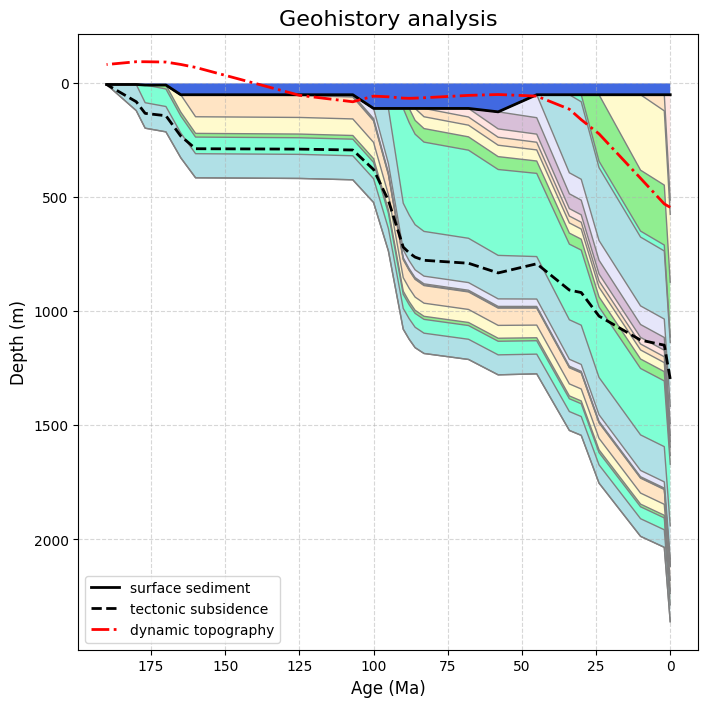

In [5]:
well, decompacted_sections = pybacktrack.backstrip_well(
    backstrip_well_filename,
    lithology_filenames=pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)

# Also calculate dynamic topography using the "M7" model.
dynamic_topography_model_M7 = pybacktrack.DynamicTopography.create_from_bundled_model(
    'M7', well.longitude, well.latitude)

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_sections, dynamic_topography_model_M7))

### Also include a model of sea level

The sea level (top of blue fill) shows a general uplift relative to the present day sea level.

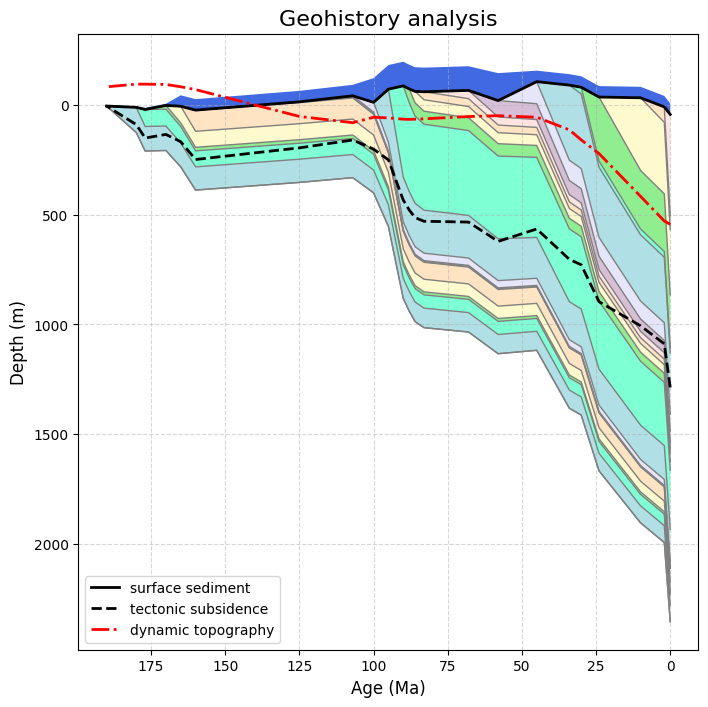

In [6]:
#
# Backstrip again, but this time with a sea level model.
#
well, decompacted_sections = pybacktrack.backstrip_well(
    backstrip_well_filename,
    lithology_filenames=pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    sea_level_model='Haq87_SealevelCurve_Longterm')

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_sections, dynamic_topography_model_M7))

## Backtrack a shallow continental drill site

Here the tectonic subsidence (black dashed line) is from an internal model of *continental* subsidence (rifting) and the paleo water depths (blue fill) are backtracked using tectonic subsidence and sediment decompaction.

Note that, unlike backstripping, dynamic topography *does* affect the tectonic subsidence here (because backtracking uses a *model* of tectonic subsidence, rather than obtaining it from recorded paleo water depths, and that model includes dynamic topography). Note that we're also plotting dynamic topography alongside tectonic subsidence.

Also note that there is a base sediment layer below the drill site (from the bottom of drill site to basement depth) since the drill site does not reach basement depth. And for this drill site the base sediment layer is quite thick because the default total sediment thickness grid is not as accurate near continental margins (compared to deeper ocean basins).

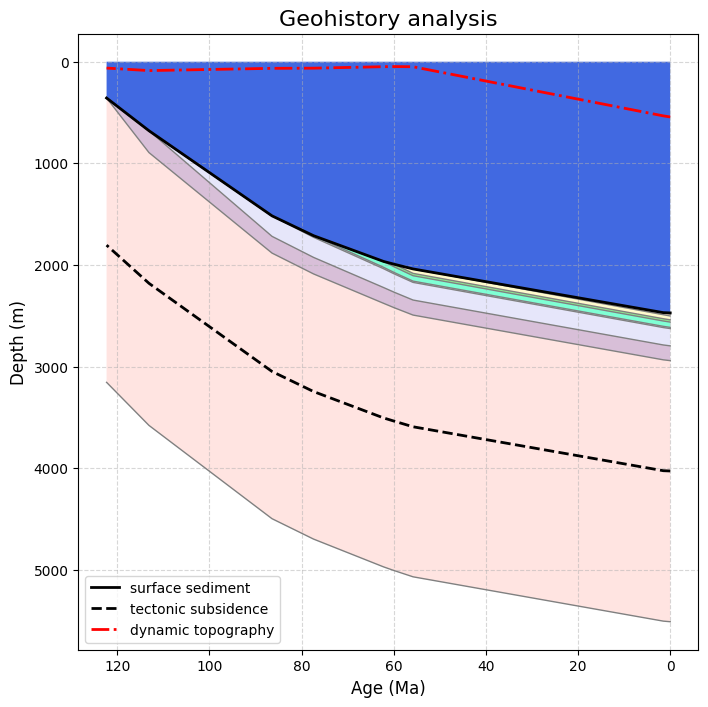

In [7]:
well, decompacted_sections = pybacktrack.backtrack_well(
    backtrack_continental_well_filename,
    lithology_filenames=pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    dynamic_topography_model='M7')

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_sections, dynamic_topography_model_M7))

## Backtrack an oceanic drill site

Here the tectonic subsidence (black dashed line) is from an internal model of *oceanic* subsidence and the paleo water depths (blue fill) are backtracked using tectonic subsidence and sediment decompaction.

Note that, unlike backstripping, dynamic topography *does* affect the tectonic subsidence here (because backtracking uses a *model* of tectonic subsidence, rather than obtaining it from recorded paleo water depths, and that model includes dynamic topography). Note that we're also plotting dynamic topography alongside tectonic subsidence.

Also note that there is a base sediment layer below the drill site (from the bottom of drill site to basement depth) since the drill site does not reach basement depth.

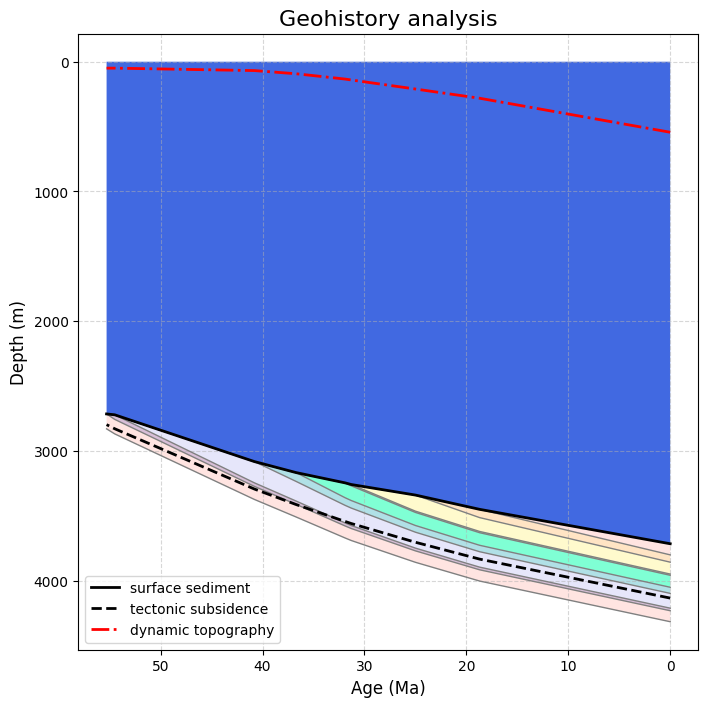

In [8]:
well, decompacted_sections = pybacktrack.backtrack_well(
    backtrack_oceanic_well_filename,
    lithology_filenames=pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    dynamic_topography_model='M7')

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_sections, dynamic_topography_model_M7))